In [1]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import random

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score

from prettytable import PrettyTable


In [4]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)


# print(len(data))
# print(train_data[0][0])
# print(test_data[0][0])
print(data[0][0])

print(len(data[1][0]))

[33.         26.          5.         11.         59.          1.12102772
  7.66666667  1.3662601  10.          0.55172414  7.          4.        ]
12


In [5]:
feature_names = ['G3.PPVT.Vocab.raw',
                 'G3.Elision.PA.raw',
                 'G3.Syn.GramCorrect.raw',
                 'G3.DigitSpan.raw',
                 'G3.WordID.raw',
                 'G3.TOWRE.raw',
                 'Subtest Depth mean',
                 'Subtest Depth stdev',
                 'Subtest Depth max',
                 'Subtest Rare Word Rate',
                 'Question Depth mean',
                 'Answer Depth mean'
                ]
print(len(feature_names))

12


In [6]:
def get_entries(data, index):
    new_data = []
    print(len(index))
#     print(index[500])
    for i in index:
        new_data.append(data[i])
    return new_data

labels = []
for entry in data:
    labels.append(entry[-1])

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for train_index, test_index in skf.split(data,labels):
    print(get_entries(data,[]))
    

0
[]
0
[]
0
[]
0
[]
0
[]


In [7]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','answers','y']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['answers'].append(entry[3])
        ds['y'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['answers'] = torch.tensor(ds['answers'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [10]:
class BertModel(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(3*sentence_dim+skill_dim*2,128)
#         self.fc2 = nn.Linear(sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question,answer):
        x1 = self.fc_skill(skills[:,:self.skill_dim])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x4 = self.fc_answer(answer)
        x = torch.cat((x1,x2,x3,x4),dim=1)
#         x = torch.cat((x1,x2),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [11]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [12]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [13]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [14]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [15]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():
        
        predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [17]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 12
dropout = 0.1
verbose = False

model_results = []

for i in range(5):
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(10)
    net = BertModel(sentence_dim, skill_dim, dropout)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    for epoch in range(max_epochs):
        train_loss, train_acc = train(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'fullmodel1.pt')
                # sentence_embedding_model
                
    print(max_stats)        
    model_results.append(max_stats)

print(model_results)

Run 0
[0.704150915145874, 0.7116402116402116, 0.7556179775280899, 0, 175]
Run 1
[0.7049056887626648, 0.7137150466045273, 0.7528089887640449, 0, 100]
Run 2
[0.702641487121582, 0.7374149659863946, 0.7294751009421265, 0, 75]
Run 3
[0.7064151167869568, 0.7310344827586207, 0.7320441988950276, 0, 150]
Run 4
[0.698867917060852, 0.6993548387096774, 0.7655367231638418, 0, 150]
[[0.704150915145874, 0.7116402116402116, 0.7556179775280899, 0, 175], [0.7049056887626648, 0.7137150466045273, 0.7528089887640449, 0, 100], [0.702641487121582, 0.7374149659863946, 0.7294751009421265, 0, 75], [0.7064151167869568, 0.7310344827586207, 0.7320441988950276, 0, 150], [0.698867917060852, 0.6993548387096774, 0.7655367231638418, 0, 150]]


In [20]:
model_1 = BertModel(64, 12, 0.1)
model_1.load_state_dict(torch.load('fullmodel1.pt'))
print(model_1)
print(test_ds['answers'].shape)
criterion = nn.BCEWithLogitsLoss()
evaluate(model_1,test_ds,criterion,matrix=False)

BertModel(
  (fc_test): Linear(in_features=768, out_features=64, bias=True)
  (fc_question): Linear(in_features=768, out_features=64, bias=True)
  (fc_answer): Linear(in_features=768, out_features=64, bias=True)
  (fc_skill): Linear(in_features=12, out_features=24, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=216, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
torch.Size([1325, 768])


(tensor(0.5831), tensor(0.6989), 0.6993548387096774, 0.7655367231638418)

In [21]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(net)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()
test_ds['answers'].requires_grad_()


attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'],test_ds['answers'])\
                          ,return_convergence_delta=True)
attr = attr[0].detach().numpy()
print(attr)

[[-1.79261617  2.53472229  0.29609573 ... -0.06367637 -1.26656509
   0.02371166]
 [ 1.67725792 -0.59827542  0.63187901 ... -0.10939019 -2.05772529
  -0.38474067]
 [-1.1994708   1.63301494  0.78497625 ... -0.05318591 -0.3557752
  -0.38341355]
 ...
 [-0.66092273  1.05578358  1.51434606 ... -0.06668292 -0.44219148
  -0.0058247 ]
 [ 3.21524868 -4.00556474  1.14844998 ... -0.1306767   0.62437726
  -1.77450868]
 [-1.45838024 -1.05639791  0.58770919 ... -0.09788842 -0.07408867
  -0.35473895]]


In [144]:
attr = attr[0].detach().numpy()
print(attr)

[[ 1.38835296 -1.62714068  0.55469045 ... -0.0255954  -0.35566213
  -0.82006692]
 [ 0.09343223 -1.35041984  1.2346954  ... -0.00675455 -0.12814117
  -0.42120651]
 [ 0.04928425 -1.25591846  1.27386323 ... -0.00311679 -0.13865868
  -0.28198756]
 ...
 [ 0.2041506  -0.7193754   1.60782337 ... -0.00503097 -0.17475127
  -0.32142604]
 [-0.03067343 -1.29522493  1.28665465 ... -0.01547032 -0.10579353
  -0.55818612]
 [ 0.49236189 -0.67942748  1.40420129 ... -0.00263785 -0.12422568
  -0.25687151]]


Average Feature Importances
G3.PPVT.Vocab.raw :  0.258
G3.Elision.PA.raw :  -0.589
G3.Syn.GramCorrect.raw :  1.197
G3.DigitSpan.raw :  0.131
G3.WordID.raw :  4.427
G3.TOWRE.raw :  0.242
Subtest Depth mean :  -0.642
Subtest Depth stdev :  -0.189
Subtest Depth max :  -0.462
Subtest Rare Word Rate :  -0.092
Question Depth mean :  -0.466
Answer Depth mean :  -0.313


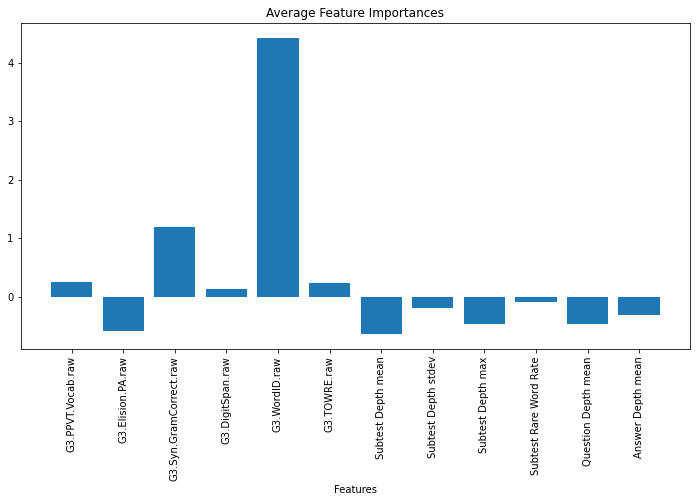

In [22]:

# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

### Simple NN model without text embeddings

In [18]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,128)
        self.out = nn.Linear(128,1)
        self.skill_dim = skill_dim
        
    def forward(self, skills):
        x1 = self.fc_skill(skills[:,:self.skill_dim])
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [23]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [24]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [29]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
skill_dim = 12
verbose = False

model_results = []

for i in range(3):
    print(f"Run {i}")
    # Get training and testing data
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    
    # fix layer initialization
    torch.manual_seed(1)
    net = SimpleNet(skill_dim)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    for epoch in range(max_epochs):
        train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[4] = epoch
                torch.save(net.state_dict(), 'basemodel_full.pt')
                
    print(max_stats)        
    model_results.append(max_stats)

print(model_results)

Run 0
[0.6641509532928467, 0.6696315120711563, 0.7401685393258427, 0, 250]
Run 1
[0.6701886653900146, 0.6699629171817059, 0.7612359550561798, 0, 150]
Run 2
[0.6830188632011414, 0.7026348808030113, 0.7537012113055181, 0, 125]
[[0.6641509532928467, 0.6696315120711563, 0.7401685393258427, 0, 250], [0.6701886653900146, 0.6699629171817059, 0.7612359550561798, 0, 150], [0.6830188632011414, 0.7026348808030113, 0.7537012113055181, 0, 125]]


In [30]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state = 4)
test_ds = create_tensors(test_data)
model_2 = SimpleNet(12)
model_2.load_state_dict(torch.load('basemodel_full.pt'))
evaluate_simple(model_2,test_ds,criterion,matrix=False)


(tensor(0.6111), tensor(0.6679), 0.6670822942643392, 0.7556497175141242)

In [55]:
def McNemar_test(pred_1,pred_2,y):
    rounded_preds_1 = torch.round(torch.sigmoid(pred_1))
    correct_1 = rounded_preds_1 == y
    
    rounded_preds_2 = torch.round(torch.sigmoid(pred_2))
    correct_2 = rounded_preds_2 == y
    
    tl = 0
    tr = 0
    bl = 0
    br = 0
    for i in range(len(correct_1)):
        if correct_1[i] == 1 and correct_2[i] == 1:
            tl += 1
        elif correct_1[i] == 1 and correct_2[i] == 0:
            tr += 1
        elif correct_1[i] == 0 and correct_2[i] == 1:
            bl += 1
        elif correct_1[i] == 0 and correct_2[i] == 0:
            br += 1
        else:
            print('Unexpected value in counting correctness',correct_1[i],correct_2[i])
    
    t = PrettyTable(['', 'Model 2 Correct', 'Model 2 Wrong'])
    t.add_row(['Model 1 Correct', tl, tr])
    t.add_row(['Model 1 Wrong', bl, br])
    print(t)

print(test_ds['subtests'].shape)
pred_1 = model_1(test_ds['skills'],test_ds['subtests'],test_ds['questions'],test_ds['answers']).squeeze(1)
pred_2 = model_2(test_ds['skills']).squeeze(1)

McNemar_test(pred_1,pred_2,test_ds['y'])

torch.Size([1325, 768])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1325x7 and 13x26)